# Evaluate initial state -> how stable is the learned model, do the dynamics converge to an equilibrium point?
1. load model
2. load initial state from evaluation file
3. let model run for a longer time from loaded initial state, evaluate output sequence

In [51]:
%load_ext autoreload
%autoreload 2

from crnn.models.model_io import get_model_from_config
from crnn.models import base as base_model
from crnn.configuration.experiment import BaseModelConfig, load_configuration
from crnn.data_io import load_input_output_from_mat
from crnn.utils.base import get_model_file_name
from crnn.models.recurrent import BasicLstm, BasicRnn
import torch
import numpy as np
import os
from matplotlib import pyplot as plt

torch.set_default_dtype(torch.double)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
experiment_names = ['P-16-joint','P-256-joint','P-128-joint','P-512-joint','P-256-separate','P-128-separate','P-512-separate']
model_names = ['tanh','lstm','lstm','lstm','lstm','lstm','lstm']

preds, x0s = [], []
for experiment_name, model_name in zip(experiment_names, model_names):
    e_m_name = f'{experiment_name}-{model_name}'
    config_file = '/Users/jack/cloud_privat/03_Promotion/_transfer/actuated_pendulum.json'
    input_output_data = f'/Users/jack/cloud_privat/03_Promotion/_transfer/{e_m_name}/seq/test_output-stability_evaluation-nonlinear-initial_state-0_M-500_T-10.mat'
    res_dir = f'/Users/jack/cloud_privat/03_Promotion/_transfer/{e_m_name}/'
    cfg = load_configuration(config_file)
    model_cfg = cfg.models[e_m_name]
    init, pred = get_model_from_config(model_cfg)

    init, pred = (
        base_model.load_model(
            model,
            os.path.join(
                res_dir, get_model_file_name(name, e_m_name)
            ),
        )
        for model, name in zip(
            [init, pred], ["initializer", "predictor"]
        )
    )
    preds.append(pred)

    io_data_list = load_input_output_from_mat(input_output_data)

    b = 1 # number of batches
    if isinstance(pred, BasicLstm):
        h0 = torch.tensor(io_data_list[0].x0[:,0,:].reshape(pred.num_layers, b, pred.nx))
        c0 = torch.tensor(io_data_list[0].x0[:,1,:].reshape(pred.num_layers, b, pred.nx))
        x0 = (h0,c0)
    else:
        x0 = torch.tensor(io_data_list[0].x0.reshape(b, pred.nx))
    x0s.append(x0)



tensor([[-0.3994]], grad_fn=<SliceBackward0>)
tensor([[-3.5138]], grad_fn=<SliceBackward0>)
tensor([[-2.6797]], grad_fn=<SliceBackward0>)
tensor([[-2.0315]], grad_fn=<SliceBackward0>)
tensor([[4.4771]], grad_fn=<SliceBackward0>)
tensor([[-4.1315]], grad_fn=<SliceBackward0>)
tensor([[4.7563]], grad_fn=<SliceBackward0>)


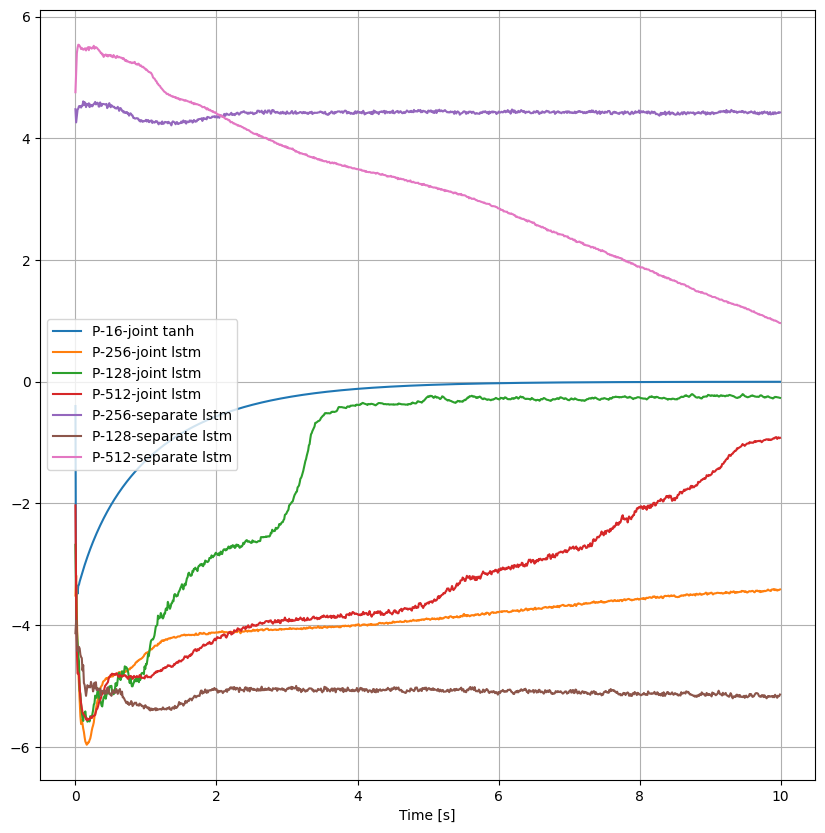

In [72]:
h, dt = 1000, 0.01
d = torch.zeros((b,h,pred.nd))
fig, ax = plt.subplots(figsize=(10,10))
t = np.linspace(0, (h-1)*dt, h)
for pred, x0, model_name, experiment_name in zip(preds, x0s, model_names, experiment_names):
    e_hat, x = pred.forward(d, x0)
    print(e_hat[:,0,:])
    ax.plot(t,e_hat.detach().numpy().squeeze(), label=f'{experiment_name} {model_name}')
    
ax.set_xlabel('Time [s]')
ax.grid()
ax.legend()




tensor([[-0.3994]], grad_fn=<SliceBackward0>)
torch.Size([1, 16])


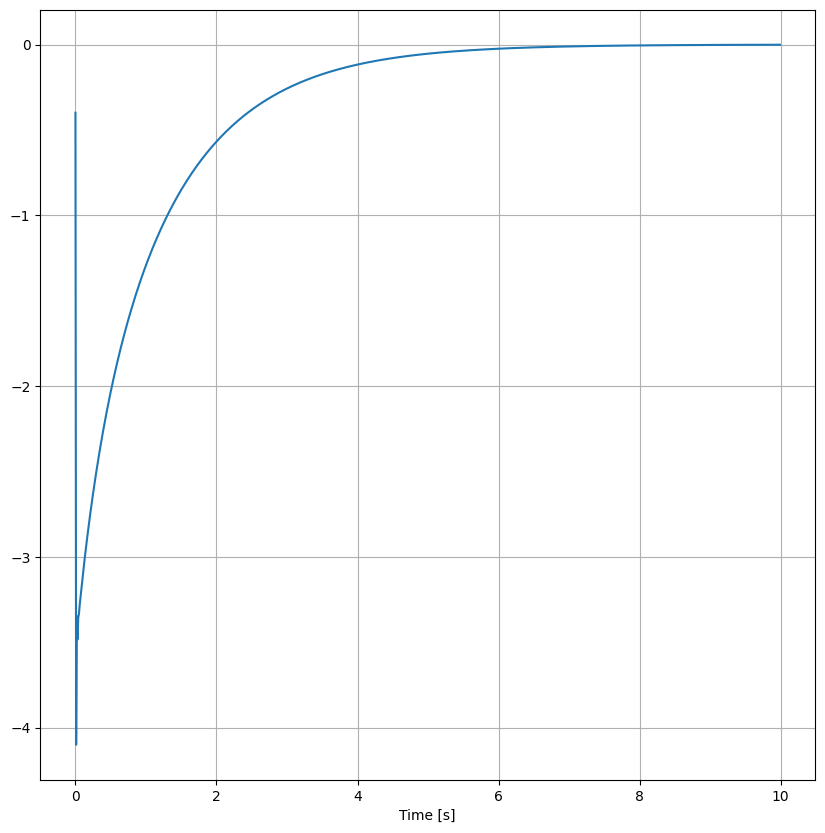